Like 4 lines of code with a straight forward concept

To read more about more scalers:
- https://scikit-learn.org/stable/modules/preprocessing.html

To play around with different scaler mixes:
- https://stats-demos.zach.wiki/

### Ryan's lesson code

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import env

from sklearn.model_selection import train_test_split
import sklearn.preprocessing

Acquire Stage

In [2]:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

query = """
select * 
from properties_2017
join predictions_2017 using(parcelid)
where transactiondate between "2017-05-01" and "2017-06-30";
"""

In [3]:
df = pd.read_sql(query, get_connection('zillow'))
df.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id,logerror,transactiondate
0,11393337,2463969,NaN,NaN,NaN,3.0,3.0,NaN,4.0,3.0,...,43439.0,2016.0,22755.0,756.94,Y,14.0,6.037235e+13,117,0.086137,2017-06-08
1,11289917,2061546,1.0,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
2,11705026,1834372,NaN,NaN,NaN,1.0,2.0,NaN,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,None,NaN,6.037232e+13,1772,-0.146056,2017-06-30
3,14269464,1923117,NaN,NaN,NaN,3.0,4.0,NaN,NaN,3.0,...,880456.0,2016.0,445569.0,9819.72,None,NaN,6.059064e+13,2028,0.021085,2017-06-01
4,11389003,2121349,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,614000.0,2016.0,449000.0,7673.19,None,NaN,6.037703e+13,3273,-0.325393,2017-06-01


In [4]:
df.shape

(21943, 62)

## Let's do a little prep on this Zillow data

In [5]:
# Some prep
df = df.rename(columns={"bedroomcnt": "bedrooms", "bathroomcnt": "bathrooms", "calculatedfinishedsquarefeet": "square_feet", "taxamount": "taxes", "taxvaluedollarcnt": "tax_value"})

In [6]:
features = [
    "parcelid",
    "bedrooms",
    "bathrooms",
    "square_feet",
    "tax_value"
]

df = df[features]
df = df.set_index("parcelid")
df.head()

,bedrooms,bathrooms,square_feet,tax_value
parcelid,,,,
11393337,3.0,3.0,1534.0,43439.0
11289917,3.0,2.0,1458.0,136104.0
11705026,2.0,1.0,1421.0,35606.0
14269464,4.0,3.0,2541.0,880456.0
11389003,3.0,2.0,1650.0,614000.0


In [7]:
# how many records do we have?
df.shape

(21943, 4)

In [8]:
# how many nulls do I have?
df.isna().sum()

bedrooms        6
bathrooms       6
square_feet    61
tax_value       6
dtype: int64

In [9]:
# Let's drop the nulls
df = df.dropna()
df.head()

,bedrooms,bathrooms,square_feet,tax_value
parcelid,,,,
11393337,3.0,3.0,1534.0,43439.0
11289917,3.0,2.0,1458.0,136104.0
11705026,2.0,1.0,1421.0,35606.0
14269464,4.0,3.0,2541.0,880456.0
11389003,3.0,2.0,1650.0,614000.0


In [10]:
def split_data(df, stratify_by=""):
    '''
    take in a DataFrame and return train, validate, and test DataFrames.
    return train, validate, test DataFrames.
    '''
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, 
                                       test_size=.3, 
                                       random_state=123)
    return train, validate, test

In [11]:
train, validate, test = split_data(df, stratify_by="tax_value")
train.head()

,bedrooms,bathrooms,square_feet,tax_value
parcelid,,,,
11834559,2.0,1.0,652.0,26038.0
14090662,3.0,1.5,1120.0,189649.0
11322593,3.0,2.0,2222.0,376790.0
10983576,4.0,3.0,1661.0,264420.0
11048674,3.0,2.0,1252.0,52552.0


<AxesSubplot:>

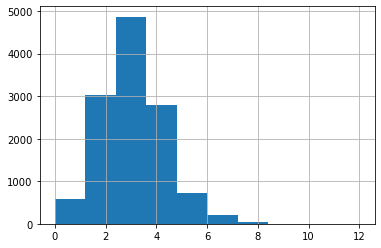

In [12]:
train.bedrooms.hist()

<AxesSubplot:>

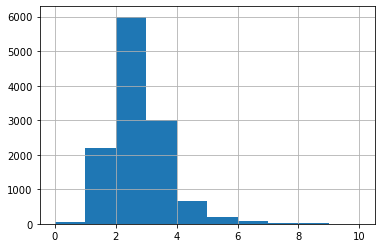

In [13]:
train.bathrooms.hist()

<AxesSubplot:>

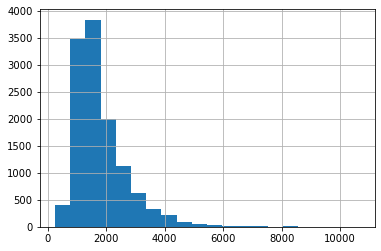

In [14]:
train.square_feet.hist(bins=20)

<AxesSubplot:>

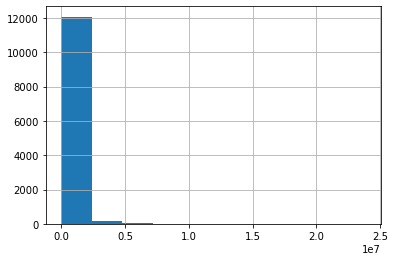

In [15]:
train.tax_value.hist()

In [16]:
train.tax_value.min()

10504.0

In [17]:
train.tax_value.max()

23858374.0

## Okay.. Scaling... Now What?
- Do the 3 step sklearn API
    1. Make the thing (make a scaler object)
    2. Fit the thing (on the train data)
    3. Use the thing

In [18]:
# Step 1 Make the thing
scaler = sklearn.preprocessing.MinMaxScaler()
# making the scaler object with MinMaxScaler
    # scales everying between 0 and 1
        # even if 1000 it willbe scaled to 0
# outliers are still part of the data after a MinMaxScaler
# first draft of scaling

In [19]:
# Fit the thing
scaler.fit(train)
    # SUPER IMPORTANT
        # fit the trianing data
        # treat your scalers liek you Maching Learning models
            # only fit training data
            # this may feel counter intuitive because you have out of sample data
                # but we cant cheat
                # our out of sample is for out of smaple data for a reason
                    # we need to preprocess first

MinMaxScaler()

In [20]:
# Run them


train_scaled = scaler.transform(train)
validate_scaled = scaler.transform(validate)
test_scaled = scaler.transform(test)

# using the same scaler on the training data for out validata and test
# transoform bring back a 2d array

In [21]:
# everything is scaled but what are rows? columns? column values?
train_scaled[0:5]

array([[0.16666667, 0.1       , 0.03937008, 0.00065138],
       [0.25      , 0.15      , 0.08430958, 0.00751199],
       [0.25      , 0.2       , 0.19012867, 0.01535928],
       [0.33333333, 0.3       , 0.13625888, 0.01064732],
       [0.25      , 0.2       , 0.09698483, 0.00176318]])

In [22]:
# hey pandas clean the data frame from above
train_scaled = pd.DataFrame(train_scaled, columns=train.columns)
validate_scaled = pd.DataFrame(validate_scaled, columns=train.columns)
test_scaled = pd.DataFrame(test_scaled, columns=train.columns)


In [23]:
# keep in midn the relative shape are the same
# just different units
train_scaled.head()

,bedrooms,bathrooms,square_feet,tax_value
0,0.166667,0.10,0.039370,0.000651
1,0.250000,0.15,0.084310,0.007512
2,0.250000,0.20,0.190129,0.015359
3,0.333333,0.30,0.136259,0.010647
4,0.250000,0.20,0.096985,0.001763


In [24]:
validate_scaled.head()

,bedrooms,bathrooms,square_feet,tax_value
0,0.250000,0.20,0.144709,0.013159
1,0.250000,0.15,0.077396,0.015745
2,0.083333,0.10,0.044171,0.006059
3,0.250000,0.20,0.099481,0.021993
4,0.333333,0.30,0.200787,0.010927


<AxesSubplot:>

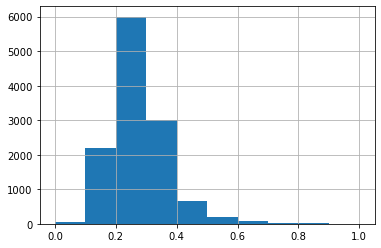

In [25]:
# the bathrooms hist looks identical to the unscaled bathroom hist
train_scaled.bathrooms.hist()

<AxesSubplot:xlabel='bedrooms', ylabel='bathrooms'>

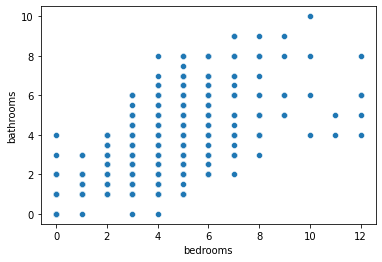

In [26]:
# do a scatter plot her
# plot out bedrooms vs bathrooms
# look at the unscaled data (train)
sns.scatterplot(x="bedrooms", y="bathrooms", data=train)

# the goal is the shape remains the same but units are differnet

<AxesSubplot:xlabel='bedrooms', ylabel='bathrooms'>

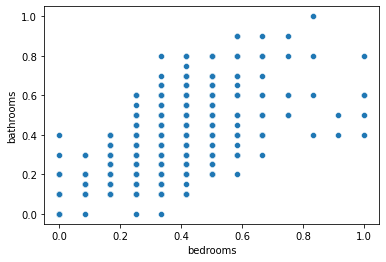

In [27]:
# now to above but wiht the scaled data
sns.scatterplot(x="bedrooms", y="bathrooms", data=train_scaled)
# holy moly its the same shape
    # shocker
# the reason its the same is because we used a linear scaler
    # just changes units, keeps the shape


### For an MVP / 1st draft
- scale our continuous values
- press forward

### Second draft
- handle some outliers
- then scale
- press forward

- If we have any clear reason to use a nonlinear scaler, do so...
    - don t have to use one.
    
- If you have categorical data in there, you would:
    - handle it seperatly
        - git dummies
            - then concat
    - if you did scale it it would jsut be a 0 and 1 nothing in between
        - but highly suggested to not scale any categorical data
    - Dont scale odinal values either
    - Only scale your continuous values
    - No need to exclude anything jsut leave it in
        - just encode before you scale

**There are some scalers built to be more robust for outliers.**

<AxesSubplot:>

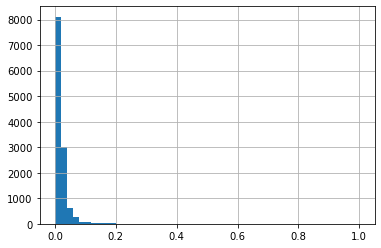

In [28]:
# when we look at this
train_scaled.tax_value.hist(bins=50)
# we cna scale in more bisn to see more detail
    # but we still see that there are outlier that are way up theere

In [29]:
# What are those values?
    # lets look at the highest ones (ascending=False)
    
train.tax_value.sort_values(ascending=False).head(30)
    # looking at tax amound for the home and the price of the home
        # the outliers are dragging out the scale
            # if we are building a predictive model this is gonna mess our stuff up
                # looking at this things normalize around 5 million- 6 million
    # if we ended up dorpping the super high outliers we would change the scale again

parcelid
11638822    23858374.0
13895633    11317682.0
11679292     9120827.0
11593948     8946027.0
11658943     8387524.0
11679205     8248250.0
11513448     8000000.0
11889295     7766509.0
12075180     7192686.0
13895592     6878585.0
11611536     6852937.0
11641808     6771406.0
14323959     6711476.0
11684160     6523867.0
11621658     6497600.0
11638557     6435575.0
11639693     6418436.0
11680016     6396074.0
12702861     6154034.0
12031310     5740519.0
12687281     5731683.0
11639145     5695440.0
11646953     5670132.0
13892580     5513250.0
11650898     5492429.0
11691860     5465000.0
13894337     5422228.0
11660472     5305202.0
13893511     5279300.0
13893456     5197978.0
Name: tax_value, dtype: float64

In [30]:
# lets exclude upper outliers
# go back to og train and make it  less than or equal to 5 mil.
x = train[train.tax_value <= 5_000_000]
x.shape

# This shouldnt be too different
# manually handling the outliers

(12222, 4)

<AxesSubplot:>

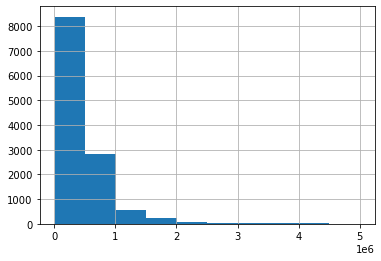

In [31]:
# now we can look at our tax value histograms
x.tax_value.hist()
# still have the skew
    # but not as skewed as it was before removeing the crazy priced homes
# 1 represents a 5 million dollar house now instead of 20 million

<AxesSubplot:>

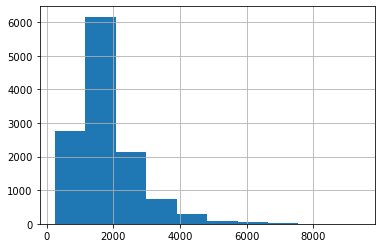

In [32]:
# now how about square foot after romoving 5 mill and up proced homes?
x.square_feet.hist()
# still a skew but not as much as befroe removing the homes

## What if we want to handle the outliers?
- if we decide we want to exclude 5 mil. and up properties with a taxable value from the data...
    - we need to rescale our data
    
Steps: 
1.  Make the og df to be a subset of properties with these outlier removed
2. then well doe our 3 split (train, validate, test)
3. make a scaler
4. fit the it on train
5. then .transform on train, validate, and test

## Where do we go from here?

1. fit our model on scaled data!
2. then we use validate/test datasers to evaluate a model, we'll use the scaled version
3. sclae your target variables too!

## Lets use the IQR Rule 
- this will help with the zillow dataset

<AxesSubplot:xlabel='tax_value'>

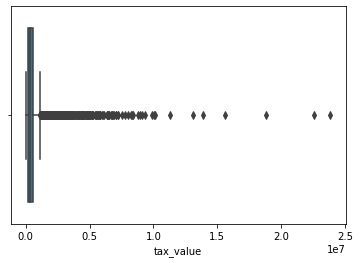

In [33]:
# boxplot before handling our outliers
sns.boxplot(x="tax_value", data=df)
# WOWZA!!

In [34]:
# Lets handle our outliers using IQR rule
train.describe()

,bedrooms,bathrooms,square_feet,tax_value
count,12253.000000,12253.000000,12253.000000,1.225300e+04
mean,3.071738,2.326696,1801.527952,4.987635e+05
std,1.118652,0.993315,936.993352,6.086271e+05
min,0.000000,0.000000,242.000000,1.050400e+04
25%,2.000000,2.000000,1190.000000,2.131000e+05
50%,3.000000,2.000000,1556.000000,3.680000e+05
75%,4.000000,3.000000,2136.000000,5.840000e+05
max,12.000000,10.000000,10656.000000,2.385837e+07


In [35]:
# Let's use IQR for the entire dataset
q1 = df.tax_value.quantile(.25)
q3 = df.tax_value.quantile(.75)
q1, q3


(212788.25, 588463.5)

In [36]:
iqr = q3 - q1
iqr

375675.25

In [37]:
# IQR has a parameter that is a 'multiplier'
    # came out in a book calle "EDA" by Tukey
# Tukey uses 1.5
# Maggie prefers 3
    # to catch more of the 
    # use if you know the outliers are part of the story 
        # we want to catch as many of them as we can

In [38]:
# Lets use Tukey's method
multiplier = 1.5
upper_bound = q3 + (multiplier * iqr)
lower_bound = q1 - (multiplier * iqr)

In [39]:

df.shape

(21882, 4)

In [40]:

lower_bound
# this would work but our lower bound is negative

-350724.625

In [41]:
# lets say give us everyhting greater than the lower bound
    # filter out the low outliers
df = df[df.tax_value > lower_bound]
df.shape
# when we carve up the df we have

(21882, 4)

In [42]:
# lets say give us everyhting less than the upper bound
df = df[df.tax_value < upper_bound]
df.shape
# when we carve up the df we have 

(20450, 4)

<AxesSubplot:xlabel='tax_value'>

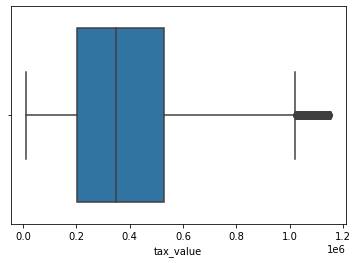

In [43]:
# boxplot after handling our outliers
    # in scientific notation land
        # so looking at it 
            #our whisker is way out there
            # the lower end is not accounting for a negaitve value
    # we are getting more of the story now
# line in the middle = median

sns.boxplot(x="tax_value", data=df)

In [44]:
# now lets split the df by tax_value
train, validate, test = split_data(df, stratify_by="tax_value")
train

,bedrooms,bathrooms,square_feet,tax_value
parcelid,,,,
11973305,3.0,1.0,1416.0,243762.0
14506461,4.0,2.5,2612.0,569334.0
14184209,4.0,3.0,3388.0,801448.0
17191188,2.0,2.0,1021.0,278999.0
11617228,2.0,2.0,1506.0,561560.0
...,...,...,...,...
14402877,0.0,0.0,770.0,284807.0
12753485,3.0,1.0,1000.0,41365.0
11072043,6.0,3.0,2940.0,649759.0


In [45]:
#scaler.inverse_transform(train_scaled)
# would unsclare the data if you needed to

# Preprocessing: Data Scaling

In this lesson we will discuss different ways to scale our data, that is, different ways to change the range of a feature or features.


## Background and Context

- Scaling is the process by which we 
    - normalize the numeric range of the atttributes of our data. 
    - There are several ways to do this, but as an example
        - we might adjust the scale of our data such that the highest value is 1 and the smallest value is 0 
            - (this is referred to as min-max scaling).



## Why Scale Data?
In general, working with the data in it's original units is preferred. However, there are a number of occasions where we might wish to work with scaled data instead:

- We might wish to visualize the combination of 2 variables with different scales.
- Some statistical tests assume normality of the data. We could apply a **non-linear** scaler to a non-normally distributed feature so that this assumption is met.
    - Linear
        - mostly used in our class
        - doesnt change the shape the data
            - all we are doing is changing our x and y axis
    - Nonlinear
        - some may be logorimic
            - that we would want to smooth out
- If two features have very different scales the feature with the larger units will have a larger impact on some model types (anywhere distance is measured).
    - This is a big deal
    - this is why we talk about how some work
        - low # of bedrooms
        - large # of square footage
            - the square footage would have that largest inpact on model types
            - but we want equal importance to each
                - scale them so that way they are scaled in the same way to achieve this equality
- Sometimes scaling the data can provide a better interpretation than the original units. Times when a log scale is helpful are an example of this.
- If we wish to combine features with different units it could be helpful to first scale both features to the same units.


Most of the time we want to work with our og units.
    - but with machine learning algorithms they will do better with scaled data
    
**Remember we pass only numeric values to the model, not the units. So model measures distance based on magnitude of numeric data regardless of units**


## When do we scale data?

- In terms of a project lifecycle, data scaling is typically performed between the initial data exploration and feature engineering. 
    - Scaling data is an activity we will do in the prepare phase of the data science pipeline. We might wish to set up multiple datasets, one with scaled units and one without. Another option is to add additional columns to our original dataset with the scaled features.

It is important that data scaling happens **after** data splitting. We don't want to leak information from our test/validate splits by using those to calculate parameters for scaling.



## How do we scale the data?

Data is scaled with either a **linear** or **non-linear** scaling method. A scaling method is typically a mathematical formula that can be used to transform a data point from the original dataset into a datapoint in the scaled dataset. A common convention is to notate the transformed data as x′ and the original as x.

Note that features are scaled independently. That is, the way we scale one feature does not impact the way we scale another feature. Put another way, imagine we have two features we wish to scale: x1 and x2. The mean of x1 plays no role in the way we scale x2.

Most scaling methods involve the calculation of a parameter from the dataset, for example the maximum data point, or the mean of the data. When calculating these parameters, it is important that they are derived from the training dataset. Once we know these parameters, we can apply the same scaling to every data point in the validate and test splits.

Most of the scaling methods we'll discuss have implementations in the `sklearn.preprocessing` module. They objects there are used like many other sklearn objects: first by fitting and then by transforming. A fit object can be used to either scale an unscaled feature or to transform a scaled feature back to the original units.

## Linear vs Non-linear Scalers

The types of scaling we can perform on our data fall into two categories: 
- linear 
    - In a linear scaling operation there is a linear correspondance between the original and the scaled value. 
    - A linear scaling operation maintains the "shape" of the distribution data and the space between data points is preserved.
- non-linear.  
    - A non-linear scaling operation changes the shape of the data, and the distance between the points is *not* preserved.

Usually we will use a linear scaler, but non-linear scalers can be useful when changing the shape of the data is desireable, for example, when we wish to use a statistical test that assumes normality, but our data is not normally distributed.

## Setup
For the remainder of this lesson we will demonstrate how to scale our data with various methods and what the results of scaling look like.

Here is a histogram of the dataset we will be working with.


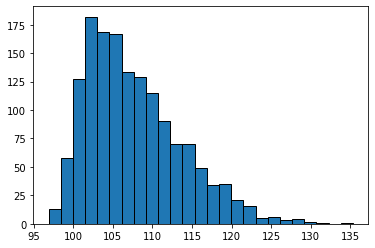

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd

np.random.seed(123)

x = stats.skewnorm(7).rvs(1500) * 10 + 100
x = x.reshape(-1, 1)

plt.hist(x, bins=25,ec='black')
print('Here is a histogram of the dataset we will be working with.')

In [47]:
x_train_and_validate, x_test = train_test_split(x, random_state=123)
x_train, x_validate = train_test_split(x_train_and_validate)

## Min-Max Scaling
Min-max scaling is a linear scaling method that transforms our features such that the range is between 0 and 1.

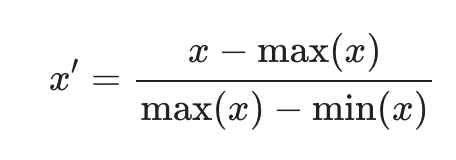

Text(0.5, 1.0, 'Scaled')

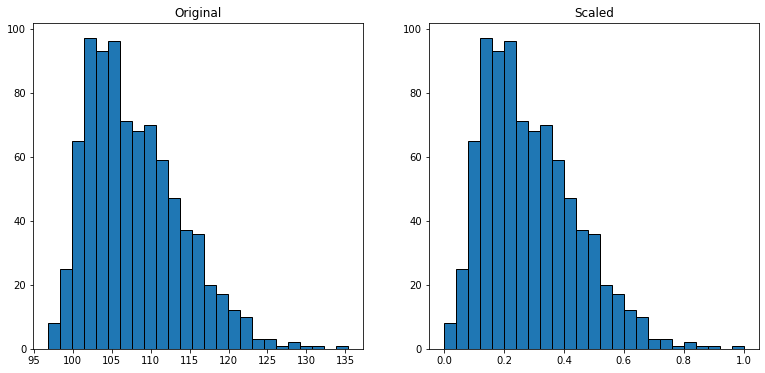

In [48]:
scaler = sklearn.preprocessing.MinMaxScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_validate_scaled = scaler.transform(x_validate)
x_test_scaled = scaler.transform(x_test)

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(x_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(x_train_scaled, bins=25, ec='black')
plt.title('Scaled')

## Standard Scaler

- **Standardization** is a **linear transformation** of our data such that is looks like the standard normal distribution. That is, it will have a mean of 0 and a standard deviation of 1.
    - when ran we wont get a range of 0 to 1
        - range will be negative and positive
            - number of stdve away from the mean
    - keeps og shape of the data
    - no garantees on what the scale is going to be

**GONNA SEE A LOT OF**

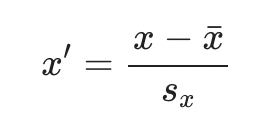

Sometimes this is split into two operations:

- **scaling** is dividing each data point by the standard deviation. This causes the resulting dataset to have a standard deviation of 1.
- **centering** is subtracting the mean from each data point. This causes the resulting dataset to have a mean of 0.

Text(0.5, 1.0, 'Scaled')

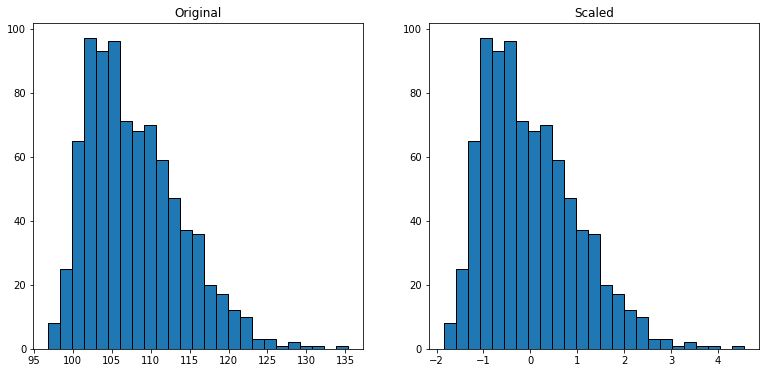

In [49]:
scaler = sklearn.preprocessing.StandardScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_validate_scaled = scaler.transform(x_validate)
x_test_scaled = scaler.transform(x_test)

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(x_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(x_train_scaled, bins=25, ec='black')
plt.title('Scaled')

## RobustScaler
A robust scaler is another linear transformation that follows the same idea as the standard scaler but uses parameters that are more robust to outliers.

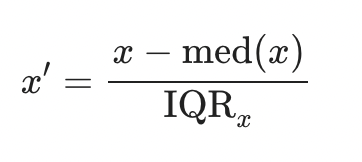

Text(0.5, 1.0, 'Scaled')

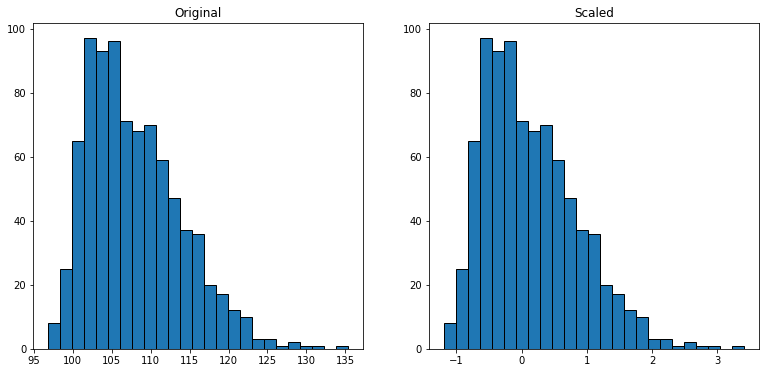

In [50]:
scaler = sklearn.preprocessing.RobustScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_validate_scaled = scaler.transform(x_validate)
x_test_scaled = scaler.transform(x_test)

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(x_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(x_train_scaled, bins=25, ec='black')
plt.title('Scaled')

## Further Reading

https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc